# MODERN PORTFOLIO THEORY & CAPITAL ASSET PRICING MODEL

## 0) Set-up

In [61]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

import random


In [62]:
from library.main import Portfolio

In [63]:
portfolio = Portfolio()

In [64]:
sp500 =portfolio.extract_tickers()
sp500

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,XYL,Xylem Inc.,Industrials,Industrial Machinery & Supplies & Components,"White Plains, New York",2011-11-01,1524472,2011
499,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
500,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
501,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927


In [65]:
# Get the first 100 tickers
list_of_tickers = random.sample(sp500["Symbol"].tolist(), 15)
list_of_tickers

['RTX',
 'APTV',
 'AOS',
 'ATO',
 'TMUS',
 'FOXA',
 'STLD',
 'ALL',
 'PYPL',
 'BIIB',
 'COP',
 'CMI',
 'MGM',
 'DD',
 'TDG']

In [66]:
start_date = "2000-01-01"
end_date = "2019-12-31"

In [67]:
portfolio.update_tickers(list_of_tickers, start_date, end_date)

=> Downloading data for APTV from 2000-01-01 to 2019-12-31
=> Downloading data for AOS from 2000-01-01 to 2019-12-31=> Downloading data for RTX from 2000-01-01 to 2019-12-31



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


=> Downloading data for ATO from 2000-01-01 to 2019-12-31
=> Downloading data for TMUS from 2000-01-01 to 2019-12-31
=> Downloading data for FOXA from 2000-01-01 to 2019-12-31


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


=> Downloading data for STLD from 2000-01-01 to 2019-12-31
=> Downloading data for ALL from 2000-01-01 to 2019-12-31
=> Downloading data for PYPL from 2000-01-01 to 2019-12-31


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


=> Downloading data for BIIB from 2000-01-01 to 2019-12-31
=> Downloading data for COP from 2000-01-01 to 2019-12-31
=> Downloading data for CMI from 2000-01-01 to 2019-12-31
=> Downloading data for MGM from 2000-01-01 to 2019-12-31


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


=> Downloading data for DD from 2000-01-01 to 2019-12-31
=> Downloading data for TDG from 2000-01-01 to 2019-12-31


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/Lin Algebra/library/plots/plots.py:197: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mean = float(info['metrics'].loc["mean"])
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/Lin Algebra/library/plots/plots.py:198: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  std = float(info['metrics'].loc["std"])
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/Lin Algebra/library/plots/plots.py:199: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  min = float(info['metrics'].loc["min"])
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/Lin Algebra/library/plots/plots.py:200: FutureWarning: Calling floa

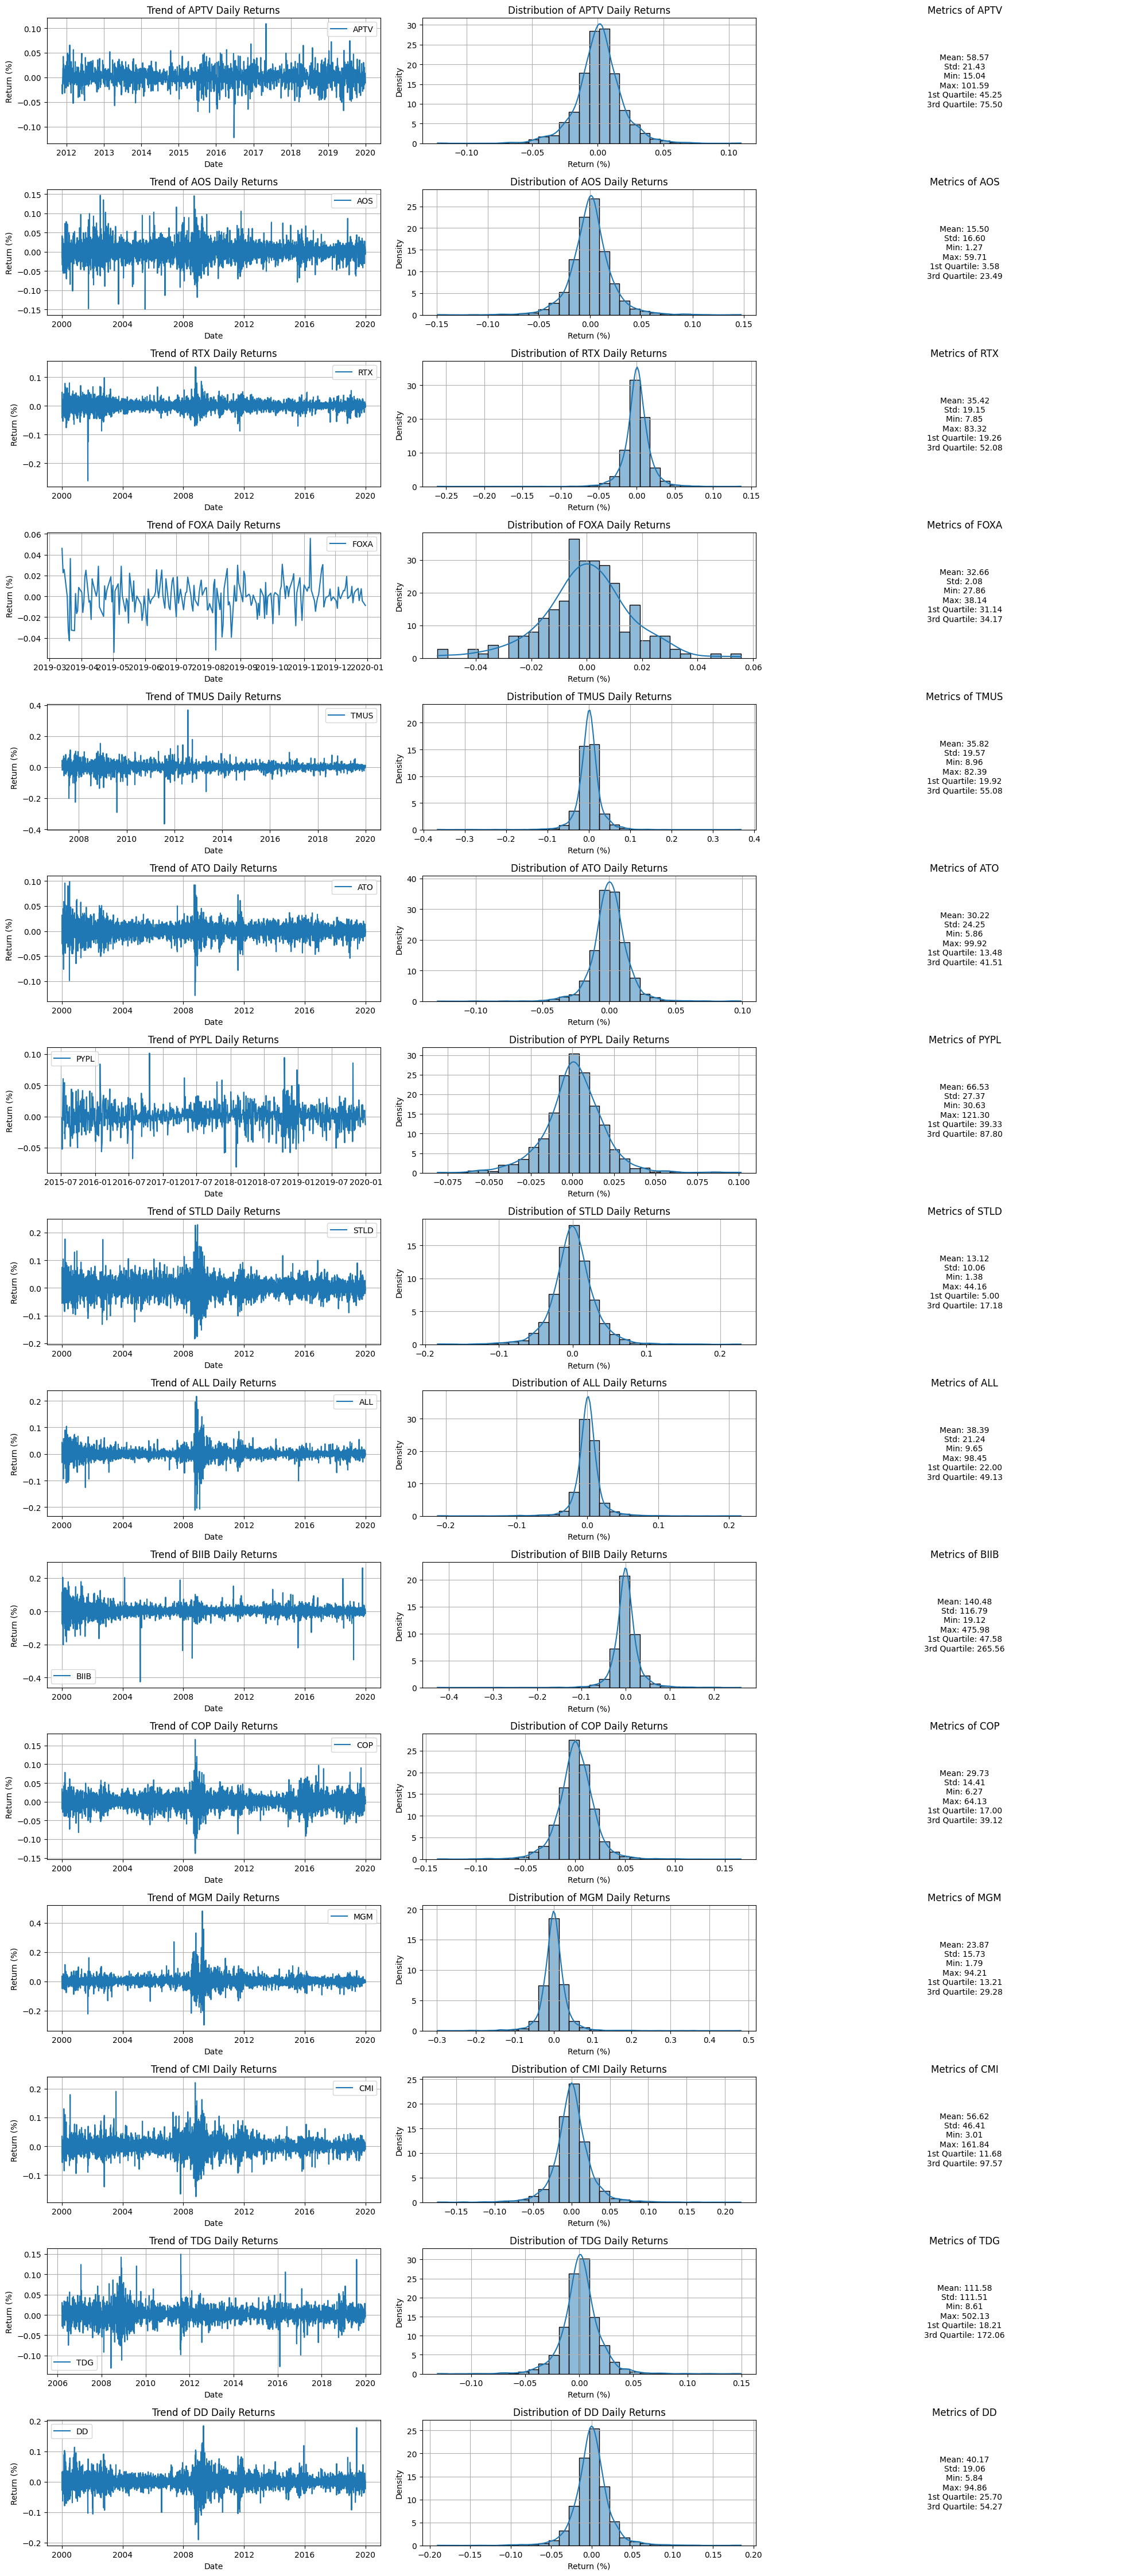

In [68]:
portfolio.analyze_securities()

Now lets observe the expected returns if we were to invest solely in a single asset

In [69]:
portfolio.data_extractor.analayze_single_security_returns()

Security: APTV
Mean expected return: 0.0010140990419257839
Risk: 0.017355642324668134


Security: AOS
Mean expected return: 0.0008044227761295457
Risk: 0.02102878271878776


Security: RTX
Mean expected return: 0.0005295328795859874
Risk: 0.016481468749115425


Security: FOXA
Mean expected return: 7.251987012311309e-05
Risk: 0.015983728268798618


Security: TMUS
Mean expected return: 0.0005777301967562663
Risk: 0.028251921538176628


Security: ATO
Mean expected return: 0.0005906889593245939
Risk: 0.013457499534787072


Security: PYPL
Mean expected return: 0.0011176761589255261
Risk: 0.018050081191399055


Security: STLD
Mean expected return: 0.0009532531885780931
Risk: 0.030297380700168637


Security: ALL
Mean expected return: 0.0005921833989256537
Risk: 0.019225309095986444


Security: BIIB
Mean expected return: 0.0008837851878085107
Risk: 0.029168051011357693


Security: COP
Mean expected return: 0.0005600335338569954
Risk: 0.018802394237295163


Security: MGM
Mean expected return: 0.

In [70]:
len(list(portfolio.securities.keys()))

15

/Users/javierdominguezsegura/Academics/College/Courses/2nd year/Lin Algebra/library/plots/plots.py:136: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


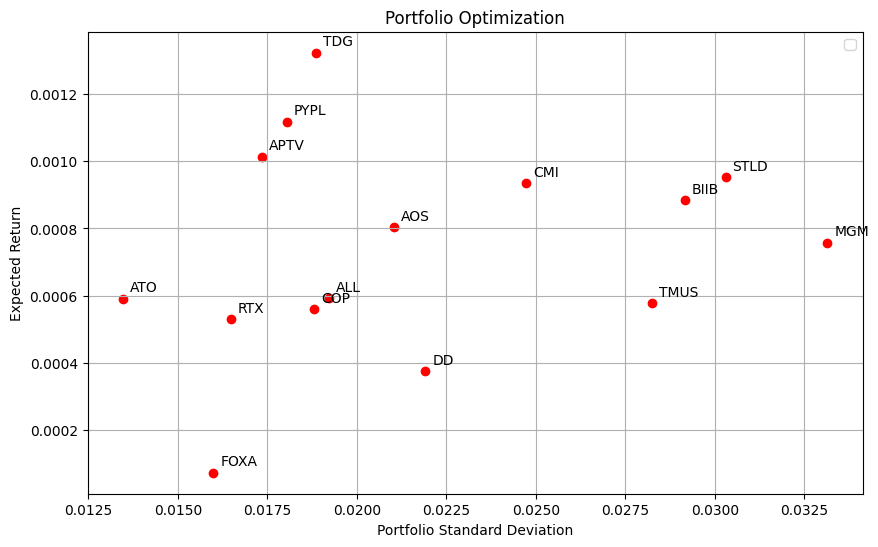

In [71]:
portfolio.plots.plot_results(include_individual_securities=True)

As you will be able to observe in our library, the way we extract returns is by levearing yfinance's dataframe column 'Adj close'. It stands for adjusted close (price) and it account for the splits and dividends over time. We then compute the percentage change over time of this returns (current value and prior). Note these measures are taken on a daily basis. If you are interested into reading more about this way of computing the returns, you can [read yahoo's blog](https://help.yahoo.com/kb/SLN28256.html#:~:text=What%20is%20the%20adjusted%20close%3F).

In accordance with the CER (cosntant expected return) model -- returns follow a i.i.d normal distribution we need to check the fitting of such distribution and alert of possible violations of this assumption.

<hr>

## 1) Extracting matrices 

In [72]:
portfolio.data_extractor.compute_matrices()

In [73]:
portfolio.data_extractor.SIGMA

array([[3.01366049e-04, 1.27010949e-04, 9.82007090e-05, 9.11211342e-05,
        9.34241481e-05, 2.66502833e-05, 1.13462756e-04, 1.34705648e-04,
        6.86237304e-05, 9.82536395e-05, 1.04354892e-04, 1.61079854e-04,
        1.29422152e-04, 9.06002628e-05, 1.27598092e-04],
       [1.27010949e-04, 4.42297652e-04, 1.47603390e-04, 6.61560521e-05,
        1.88952823e-04, 9.10732113e-05, 1.07104679e-04, 2.40022367e-04,
        1.53002578e-04, 1.33906328e-04, 1.28938054e-04, 2.33234648e-04,
        2.27380303e-04, 1.67555624e-04, 1.90783761e-04],
       [9.82007090e-05, 1.47603390e-04, 2.71692837e-04, 6.93058264e-05,
        1.41532743e-04, 7.96429646e-05, 8.72875352e-05, 2.13661666e-04,
        1.41525184e-04, 1.29471885e-04, 1.25716037e-04, 2.08873872e-04,
        2.22977393e-04, 1.44471154e-04, 1.90524824e-04],
       [9.11211342e-05, 6.61560521e-05, 6.93058264e-05, 2.56744320e-04,
        3.19536939e-05, 3.34896021e-06, 3.88046873e-05, 9.57308461e-05,
        2.47330623e-05, 2.72908942e-0

In [74]:
portfolio.data_extractor.SIGMA_INV

array([[ 4.72273073e+03, -5.47785506e+02, -3.26567441e+02,
        -1.02548382e+03,  3.60926503e+00,  4.42460059e+02,
        -9.46588478e+02,  4.48098235e+01,  1.32614704e+02,
        -1.83404811e+02, -4.10326494e+02, -1.60433783e+02,
        -1.26943359e+02, -3.78500999e+01, -3.25283898e+02],
       [-5.47785506e+02,  3.49520878e+03, -2.41243417e+02,
        -2.74094924e+02, -1.94883031e+02, -6.27579602e+02,
        -2.96788867e+02, -1.47300382e+02, -3.64466847e+02,
        -6.52856461e+01,  1.82754716e+02, -7.16873857e+01,
        -3.36534160e+02, -5.06249233e+02, -2.22637531e+02],
       [-3.26567441e+02, -2.41243417e+02,  6.99728048e+03,
        -8.59672693e+02,  1.91798975e+01, -9.12773431e+02,
        -4.45986966e+02, -1.03252419e+02, -7.19680462e+02,
        -2.32626350e+02,  1.39427678e+01, -1.17175109e+02,
        -9.84386466e+02, -7.00509560e+02, -8.79091494e+02],
       [-1.02548382e+03, -2.74094924e+02, -8.59672693e+02,
         4.69808274e+03,  1.23887637e+02,  6.15610816

In [75]:
portfolio.data_extractor.MU

array([[1.01409904e-03],
       [8.04422776e-04],
       [5.29532880e-04],
       [7.25198701e-05],
       [5.77730197e-04],
       [5.90688959e-04],
       [1.11767616e-03],
       [9.53253189e-04],
       [5.92183399e-04],
       [8.83785188e-04],
       [5.60033534e-04],
       [7.57843874e-04],
       [9.34316654e-04],
       [1.32320643e-03],
       [3.74057267e-04]])

In [76]:
portfolio.data_extractor.ONE_VECTOR

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

We want to smooth out noise, thus we can cleverly apply PCA to the Sigma matrix. This will significanlty improve the robustness of our model. This is accomplished by making the model less sensitive to estimation errors in the original sigma

In [77]:
portfolio.data_extractor.pca_shrinkage(var_threshold=0.90)

(array([[2.92142007e-04, 1.26651361e-04, 1.01669886e-04, 9.95476567e-05,
         9.37335318e-05, 3.09137248e-05, 1.14380941e-04, 1.34000960e-04,
         6.52036777e-05, 9.86207287e-05, 1.03956799e-04, 1.61285320e-04,
         1.28023189e-04, 9.47148008e-05, 1.27269293e-04],
        [1.26651361e-04, 4.42706888e-04, 1.49419601e-04, 6.55334059e-05,
         1.89088020e-04, 8.79629621e-05, 1.05709549e-04, 2.39809112e-04,
         1.52185742e-04, 1.34080104e-04, 1.30334783e-04, 2.33243395e-04,
         2.26386265e-04, 1.68979084e-04, 1.91014853e-04],
        [1.01669886e-04, 1.49419601e-04, 2.89319936e-04, 5.87957044e-05,
         1.41776573e-04, 6.69283542e-05, 8.43427903e-05, 2.14110353e-04,
         1.40201564e-04, 1.29020453e-04, 1.30038244e-04, 2.08955307e-04,
         2.19803227e-04, 1.39719791e-04, 1.88247398e-04],
        [9.95476567e-05, 6.55334059e-05, 5.87957044e-05, 2.51992269e-04,
         3.13235643e-05, 7.18578695e-06, 4.18488060e-05, 9.67856099e-05,
         3.02749309e-05

In [78]:
# Lets update the class with the new computed data
portfolio.update_data()

# 2) Global Minimum Variance Portfolio
A baseline for our modelling in the risk-return space

In [79]:
results_dict = portfolio.compute_global_minimum_variance_portfolio()

In [80]:
results_dict["weights"], results_dict["weights"].sum()

(array([[ 0.08581182],
        [-0.00898217],
        [ 0.09306739],
        [ 0.27145888],
        [ 0.01696022],
        [ 0.33619053],
        [ 0.11967015],
        [-0.05083981],
        [ 0.08573194],
        [ 0.02654968],
        [ 0.04127034],
        [-0.02903348],
        [-0.04647059],
        [ 0.08425923],
        [-0.02564411]]),
 np.float64(1.0))

In [81]:
results_dict["expected_return"], results_dict["expected_variance"]

(0.0005762612630834012, 8.585854139929435e-05)

# 3) Efficient Portfolios
Note we do not restrict to long positions on the securities. We allow for shorting

In [82]:
df = portfolio.compute_efficient_frontier()
df

,weights,variance,sigma,expected_return
0,"[[-0.1071996730016346], [-0.008089573327355062...",0.000132,0.011487,0.000073
1,"[[-0.10235918869774827], [-0.00811195849963016...",0.000130,0.011388,0.000085
2,"[[-0.09751870439386198], [-0.00813434367190534...",0.000127,0.011289,0.000098
3,"[[-0.09267822008997562], [-0.00815672884418042...",0.000125,0.011193,0.000110
4,"[[-0.08783773578608936], [-0.00817911401645551...",0.000123,0.011098,0.000123
...,...,...,...,...
95,"[[0.3526463358675628], [-0.010216164693489516]...",0.000174,0.013190,0.001273
96,"[[0.35748682017144895], [-0.010238549865764585...",0.000177,0.013311,0.001285
97,"[[0.36232730447533523], [-0.010260935038039681...",0.000180,0.013434,0.001298
98,"[[0.3671677887792216], [-0.010283320210314723]...",0.000184,0.013558,0.001311


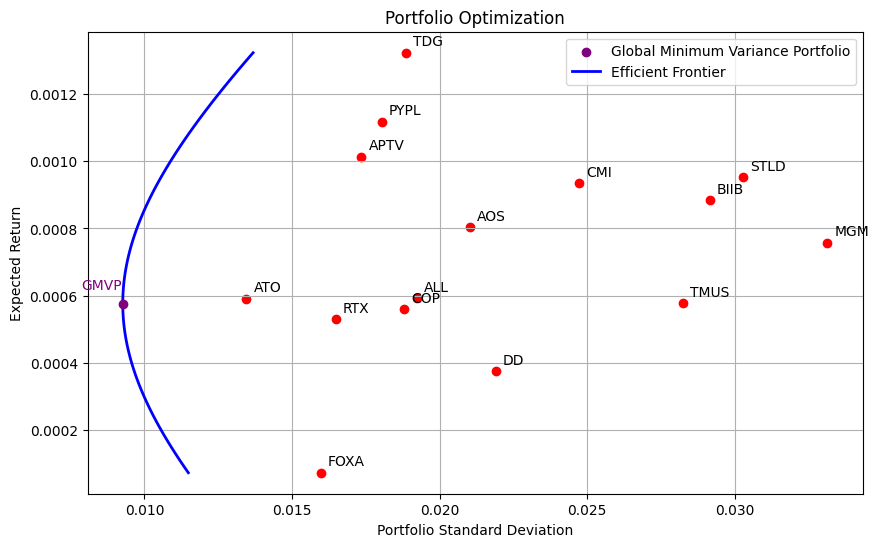

In [83]:
portfolio.plots.plot_results(include_gmvp=True, include_efficient_frontier=True, include_individual_securities=True)

# 4) Capital Asset Pricing Model

In [84]:
annual_risk_free_rate = 0.02
daily_risk_free_rate = (1 + annual_risk_free_rate)**(1/252) - 1 # Formula (assuming 252 days of trading)
daily_risk_free_rate

7.85849419846496e-05

In [85]:
results_dict = portfolio.compute_sharpe_portfolio(daily_risk_free_rate)

In [86]:
results_dict["weights"]

array([[ 0.44965319],
       [-0.01066478],
       [-0.10886518],
       [-0.19843233],
       [-0.04293491],
       [ 0.283901  ],
       [ 0.31929171],
       [ 0.04113223],
       [ 0.0148301 ],
       [ 0.05524271],
       [-0.0849798 ],
       [-0.05300414],
       [ 0.07440699],
       [ 0.50016629],
       [-0.23974309]])

In [87]:
results_dict["expected_return"]

0.0015258521766331845

In [88]:
results_dict["expected_variance"]

0.00024968086387468913

In [89]:
print(f'Daily Sharpe ratio: {results_dict["sharpe_ratio"]} \nAnnualized Sharpe ratio: {results_dict["sharpe_ratio"] * np.sqrt(252)}')

Daily Sharpe ratio: 0.09159169599515099 
Annualized Sharpe ratio: 1.453973098570801


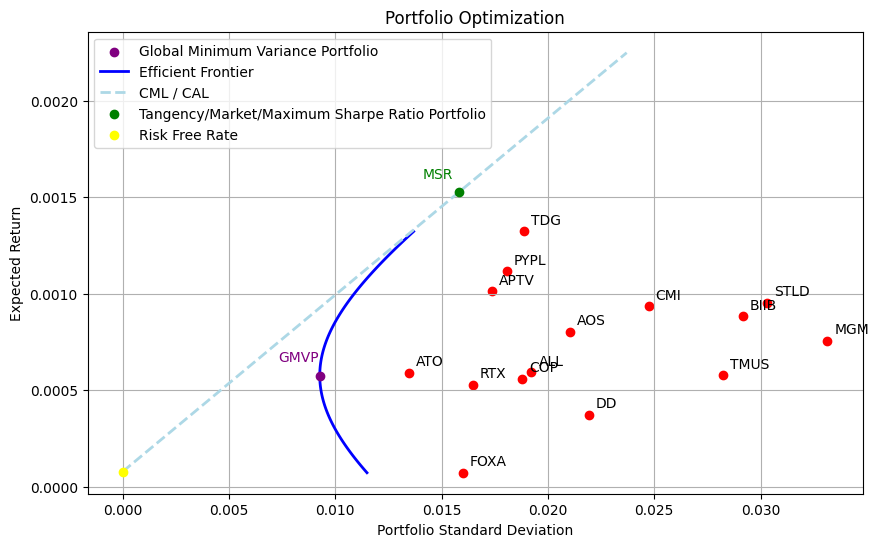

In [90]:
portfolio.plots.plot_results(include_gmvp=True, include_efficient_frontier=True, include_sharpe=True, include_individual_securities=True)